# DEPTH BASED COMPARISON PLOTS 

Code for the generation of the Depth based comparison plots. These plots are used to evaluate weather it is necessary to exploit the depth of a node in the computation of the Importance score of the Isolation Tree's nodes.  

In [1]:
import sys
import numpy as np
from datetime import datetime
import pandas as pd
import argparse
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import sklearn
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.forests import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.metrics import classification_report,average_precision_score,roc_auc_score
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

Example for the Annthyroid Dataset

In [26]:
name = 'annthyroid'
X,y = dataset(name)
X,y = downsample(X,y)
EDIFFI = Extended_DIFFI_original(300,subsample_size=min(256,X.shape[0]),plus=0)
EDIFFI.fit(X)

annthyroid 

[numero elementi = 7062]
[percentage outliers = 0.07561597281223449]
[number features = 6]
[number outliers = 534]
downsampled to 2500
(2500, 6)


For every Isolation Tree in the forest (all the trees are contained in EDIFFI.forest) the make_importance function,both with and without the depth coefficient, is called.  

The make_importance function iterates over the samples in X and creates all the hyperplanes at every node of a tree and computes the cumulative importance score for every node using the equation: 

np.abs(n)*(N/(self.nodes[id]["numerosity"]+1))  -> without depth


np.abs(n)*(N/(self.nodes[id]["numerosity"]+1)) *1/(1+depth) -> with depth 

In [27]:
for i in range(len(EDIFFI.forest)):
    EDIFFI.forest[i].make_importance(X,False)
    EDIFFI.forest[i].make_importance(X,True)

For each depth value we create a key in the values dictionary. Inside this key we create a dictionary with the depth_based and not_depth_based keys that contains the left and right importance values on that node. 

In [28]:
values = {}
for node in EDIFFI.forest[i].nodes:
    k=EDIFFI.forest[i].nodes[node]
    if k["point"] is not None:
        depth = k["depth"]
        try:
            values[depth]["depth_based"].append(k["left_importance_depth"])
            values[depth]["not_depth_based"].append(k["left_importance"])
            values[depth]["depth_based"].append(k["right_importance_depth"])
            values[depth]["not_depth_based"].append(k["right_importance"])
        except:        
            values[depth]={}
            values[depth]["depth_based"] = []
            values[depth]["not_depth_based"] = []
            values[depth]["depth_based"] = []
            values[depth]["not_depth_based"] = []
            values[depth]["depth_based"].append(k["left_importance_depth"])
            values[depth]["not_depth_based"].append(k["left_importance"])
            values[depth]["depth_based"].append(k["right_importance_depth"])
            values[depth]["not_depth_based"].append(k["right_importance"])

In [29]:
depth_based_values_mean=[]
values_mean=[]
mean = []
mean_depth = []
for i in values:
    depth_based_values_mean.append([np.percentile(np.array(values[i]["depth_based"]),p) for p in [15,50,75]])
    values_mean.append([np.percentile(np.array(values[i]["not_depth_based"]),p) for p in [15,50,75]])    
    mean.append([np.std(np.array(values[i]["not_depth_based"])),np.mean(np.array(values[i]["not_depth_based"]))] )  
    mean_depth.append([np.std(np.array(values[i]["depth_based"])),np.mean(np.array(values[i]["depth_based"]))]  ) 

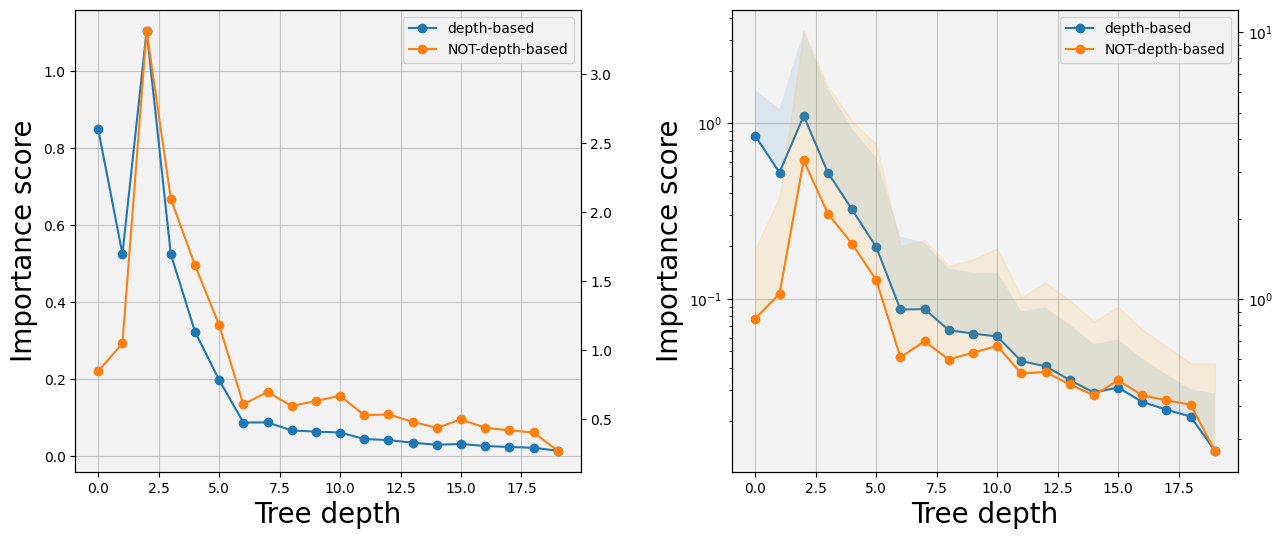

In [30]:
plt.style.use('default')
plt.rcParams['axes.facecolor'] = '#F2F2F2'
plt.rcParams['axes.axisbelow'] = True

x_value = np.arange(0,len(depth_based_values_mean),1)
fig,ax = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.3)

ax[0].grid(alpha=0.7)
ax[1].grid(alpha=0.7)

ax4 = ax[0].twinx()
lns0 = ax[0].plot(x_value, [m[1] for m in mean_depth],"o-", label = "depth-based")
#ax[1,0].fill_between(x_value,[m[0] for m in depth_based_values_mean], [m[0] for m in depth_based_values_mean], alpha=.1)
lns01 = ax4.plot(x_value, [m[1] for m in mean],"o-", c="tab:orange", label = "NOT-depth-based")
#ax[1,0].fill_between(x_value,[m[0] for m in values_mean], [m[0] for m in values_mean], alpha=.1)
lns0 = lns0+lns01
labs0 = [l.get_label() for l in lns0]
#ax[0].set_title(name + " Mean of the score over the depth")
ax[0].set_xlabel("Tree depth",fontsize=20)
ax[0].set_ylabel("Importance score",fontsize=20)
ax[0].legend(lns0, labs0, loc=0)

ax5 = ax[1].twinx()
lns1 = ax[1].plot(x_value, [m[1] for m in mean_depth],"o-", label = "depth-based")
ax[1].fill_between(x_value,[m[1]+m[0] for m in mean_depth], [m[1] for m in mean_depth], alpha=.1)
lns2 = ax5.plot(x_value, [m[1] for m in mean],"o-",c="tab:orange", label = "NOT-depth-based",)
ax5.fill_between(x_value,[m[1]+m[0] for m in mean], [m[1] for m in mean], color='orange',alpha=.1)
#ax[1].set_title(name + " Mean of the score and positive standard deviation band")
ax[1].set_yscale("log")
ax5.set_yscale("log")
ax[1].set_xlabel("Tree depth",fontsize=20)
ax[1].set_ylabel("Importance score",fontsize=20)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[1].legend(lns, labs, loc=0)
path='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'
plt.savefig(path+'\\results\\davide\\depth_comparison\\depth_comparison_plot_'+name+'.pdf')
plt.show()